# ❤️🔬 Heartbeat Classification: Detecting Normal vs. Abnormal Heartbeats

## 🔹 Introduction:
The human heart is one of the most vital organs, tirelessly pumping blood throughout our body. But what happens when its rhythm becomes irregular? 🏥 In this project, we leverage machine learning to classify normal vs. abnormal heartbeats using real-world ECG (electrocardiogram) data from the PTB Diagnostic ECG Database from Kaggle. By training a deep learning model, we aim to detect potential heart conditions, helping in early diagnosis of cardiac abnormalities. 💡❤️

## 📊 Dataset Overview
We use the PTBDB dataset from Kaggle, which contains:

Link: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
> ✅ Normal heartbeats (from healthy individuals) 💙

> ✅ Abnormal heartbeats (from patients with heart disease) 💔

The dataset consists of ECG signals recorded at different time intervals, which we analyze and classify using AI models.

In [1]:
# 1. Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber, CosineSimilarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 2. Utility Functions
def predict(model, data):
    predictions = model.predict(data)
    loss = np.mean(np.abs(data - predictions), axis=1)
    return predictions, loss

def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Actual")
    ax.plot(pred[0], label="Predicted")
    ax.fill_between(range(1, 189), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=7)
    ax.set_title(f"{title} (loss: {loss[0]:.3f})", fontsize=9.5)

def get_reconstruction_error(model, data):
    predictions = model.predict(data)
    return np.mean(np.abs(data - predictions), axis=1)

def classify_errors(errors, threshold):
    return np.array(errors > threshold, dtype=int)

In [7]:
import os

# Define Kaggle credentials directory
KAGGLE_DIR = "/root/.kaggle"

# Create the directory if it doesn't exist
os.makedirs(KAGGLE_DIR, exist_ok=True)

# Move the kaggle.json file (ensure you uploaded it first)
!mv kaggle.json {KAGGLE_DIR}/

# Set permissions
!chmod 600 {KAGGLE_DIR}/kaggle.json

# Install Kaggle API (if not installed)
!pip install -q kaggle

# Download the dataset
!kaggle datasets download -d shayanfazeli/heartbeat

# Unzip the dataset
!unzip -o heartbeat.zip -d heartbeat_data

# List files to verify
!ls heartbeat_data


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
100% 98.8M/98.8M [00:05<00:00, 24.1MB/s]
100% 98.8M/98.8M [00:05<00:00, 18.6MB/s]
Archive:  heartbeat.zip
  inflating: heartbeat_data/mitbih_test.csv  
  inflating: heartbeat_data/mitbih_train.csv  
  inflating: heartbeat_data/ptbdb_abnormal.csv  
  inflating: heartbeat_data/ptbdb_normal.csv  
mitbih_test.csv  mitbih_train.csv  ptbdb_abnormal.csv  ptbdb_normal.csv


# Loading the data

In [8]:
# 3. Data Loading and Pre-processing
normal_df = pd.read_csv("heartbeat_data/ptbdb_normal.csv", sep=',').drop("target", axis=1, errors="ignore")
anomaly_df = pd.read_csv("heartbeat_data/ptbdb_abnormal.csv", sep=',').drop("target", axis=1, errors="ignore")

normal = normal_df.to_numpy()
anomaly = anomaly_df.to_numpy()
X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)


# Data Visualization

In [9]:
# Visualize the first and last few rows of normal data
print("First 5 rows of normal data:")
print(normal_df.head())

print("\nLast 5 rows of normal data:")
print(normal_df.tail())

# Visualize the first and last few rows of anomaly data
print("\nFirst 5 rows of anomaly data:")
print(anomaly_df.head())

print("\nLast 5 rows of anomaly data:")
print(anomaly_df.tail())

First 5 rows of normal data:
   1.000000000000000000e+00  9.003241658210754395e-01  \
0                  1.000000                  0.794681   
1                  0.909029                  0.791482   
2                  1.000000                  0.478893   
3                  1.000000                  0.867238   
4                  0.948983                  0.505265   

   3.585899472236633301e-01  5.145867168903350830e-02  \
0                  0.375387                  0.116883   
1                  0.423169                  0.186712   
2                  0.056760                  0.064176   
3                  0.201360                  0.099349   
4                  0.004176                  0.022513   

   4.659643396735191345e-02  1.268233358860015869e-01  \
0                  0.000000                  0.171923   
1                  0.000000                  0.007836   
2                  0.081289                  0.072732   
3                  0.141336                  0.120934   


# Plotting one graph each of normal and abnormal signal

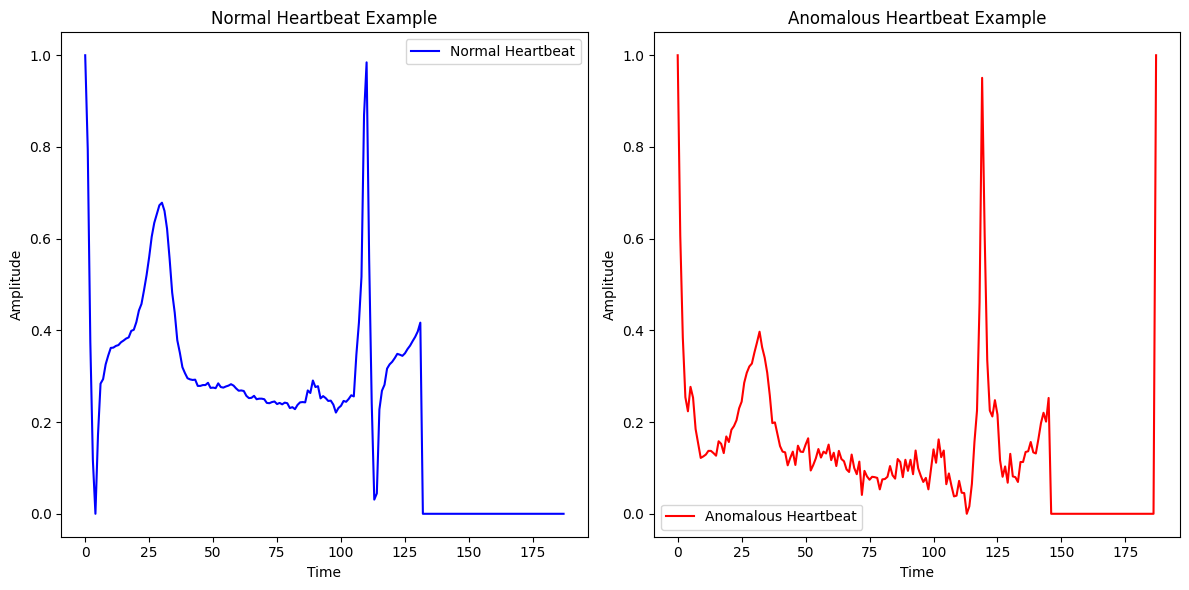

In [10]:
# Plot a few samples of heartbeats
plt.figure(figsize=(12, 6))

# Plot normal heartbeat signal
plt.subplot(1, 2, 1)
plt.plot(normal[0], label="Normal Heartbeat", color='blue')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Normal Heartbeat Example")
plt.legend()

# Plot abnormal heartbeat signal
plt.subplot(1, 2, 2)
plt.plot(anomaly[0], label="Anomalous Heartbeat", color='red')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Anomalous Heartbeat Example")
plt.legend()

plt.tight_layout()
plt.show()

# Comparing normal and abnormal signal through a graph seperately

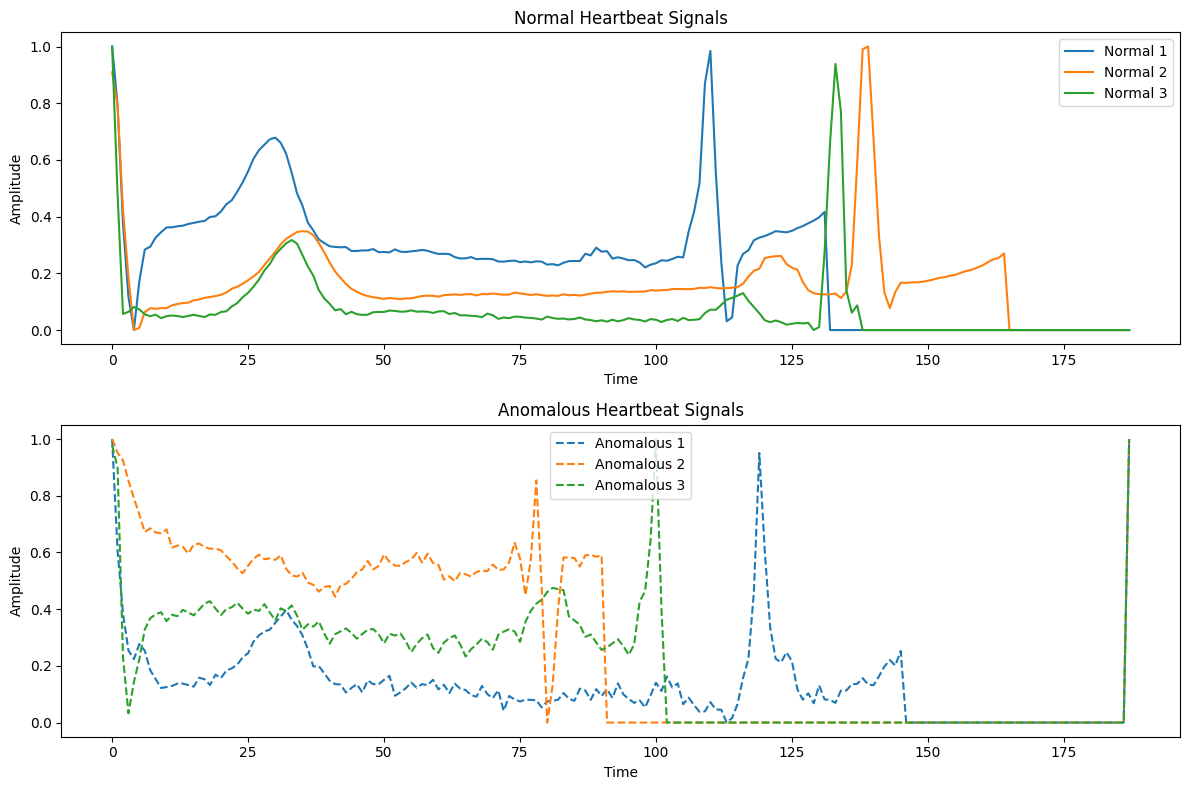

In [11]:
# Plot multiple normal and anomalous heartbeat signals
plt.figure(figsize=(12, 8))

# Plot a few normal heartbeat signals
for i in range(3):  # Adjust the number of examples as needed
    plt.subplot(2, 1, 1)
    plt.plot(normal[i], label=f"Normal {i+1}")

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Normal Heartbeat Signals")
plt.legend()

# Plot a few anomalous heartbeat signals
for i in range(3):  # Adjust the number of examples as needed
    plt.subplot(2, 1, 2)
    plt.plot(anomaly[i], label=f"Anomalous {i+1}", linestyle='dashed')

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Anomalous Heartbeat Signals")
plt.legend()

plt.tight_layout()
plt.show()

# Comparing normal and abnormal signal through a graph

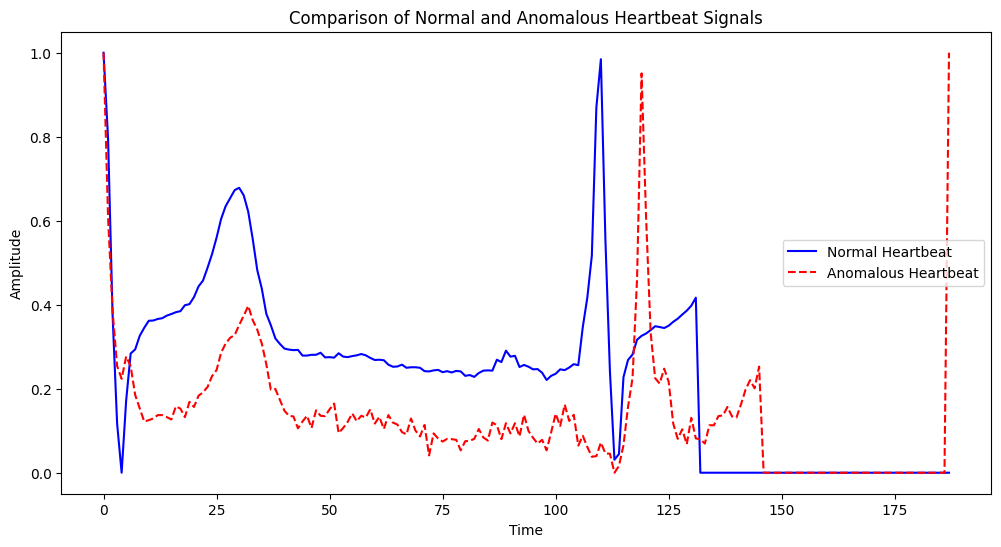

In [12]:
# Plot a direct comparison of one normal and one abnormal signal
plt.figure(figsize=(12, 6))
plt.plot(normal[0], label="Normal Heartbeat", color='blue')
plt.plot(anomaly[0], label="Anomalous Heartbeat", color='red', linestyle='dashed')

# Labels and title
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Comparison of Normal and Anomalous Heartbeat Signals")
plt.legend()

# Show the plot
plt.show()

In [13]:
# 4. Model Definition
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


In [14]:
input_dim = X_train.shape[-1]
latent_dim = 32
epochs = 100
batch_size = 64
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)
loss_functions = {'MAE': MeanAbsoluteError(), 'MSE': MeanSquaredError(), 'Huber': Huber(), 'CosineSimilarity': CosineSimilarity()}
best_loss = float('inf')
best_model = None
best_loss_function = None


In [15]:
# Ground truth for validation
y_true_normal = np.zeros(len(X_test))
y_true_anomaly = np.ones(len(anomaly))
y_test = np.concatenate([y_true_normal, y_true_anomaly])
X_combined_test = np.concatenate([X_test, anomaly])


Using GPU for training.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation Accuracy using MAE: 99.20%
Validation Reconstruction Error using MAE: 0.028576
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


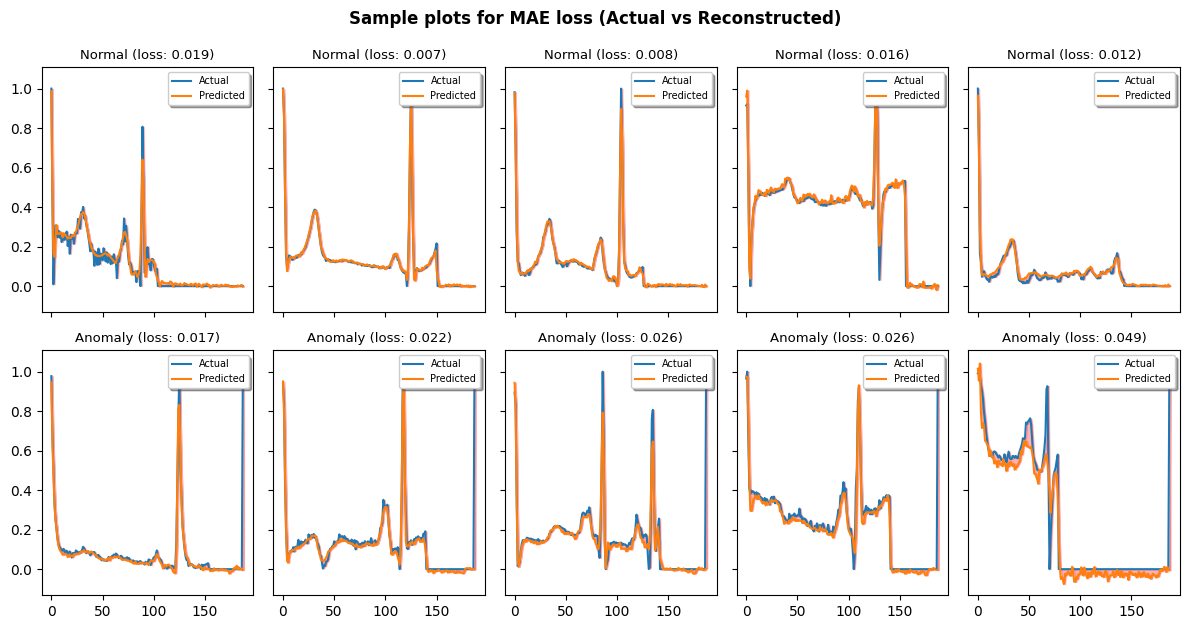

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Accuracy using MSE: 74.21%
Validation Reconstruction Error using MSE: 0.036870
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


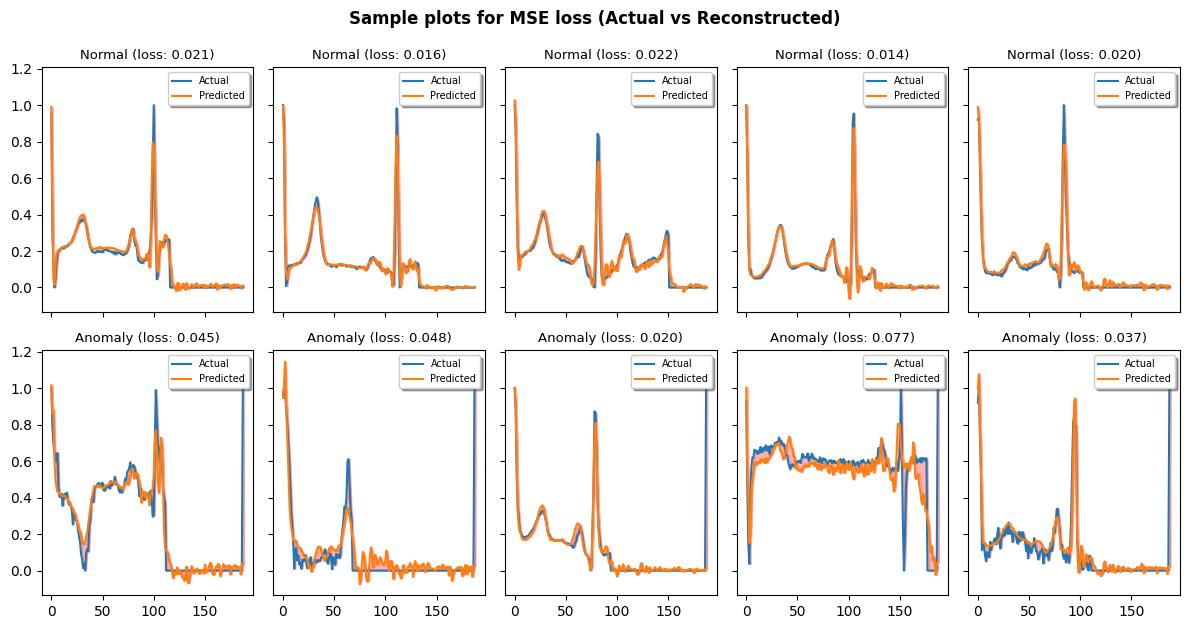

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation Accuracy using Huber: 43.30%
Validation Reconstruction Error using Huber: 0.042322
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


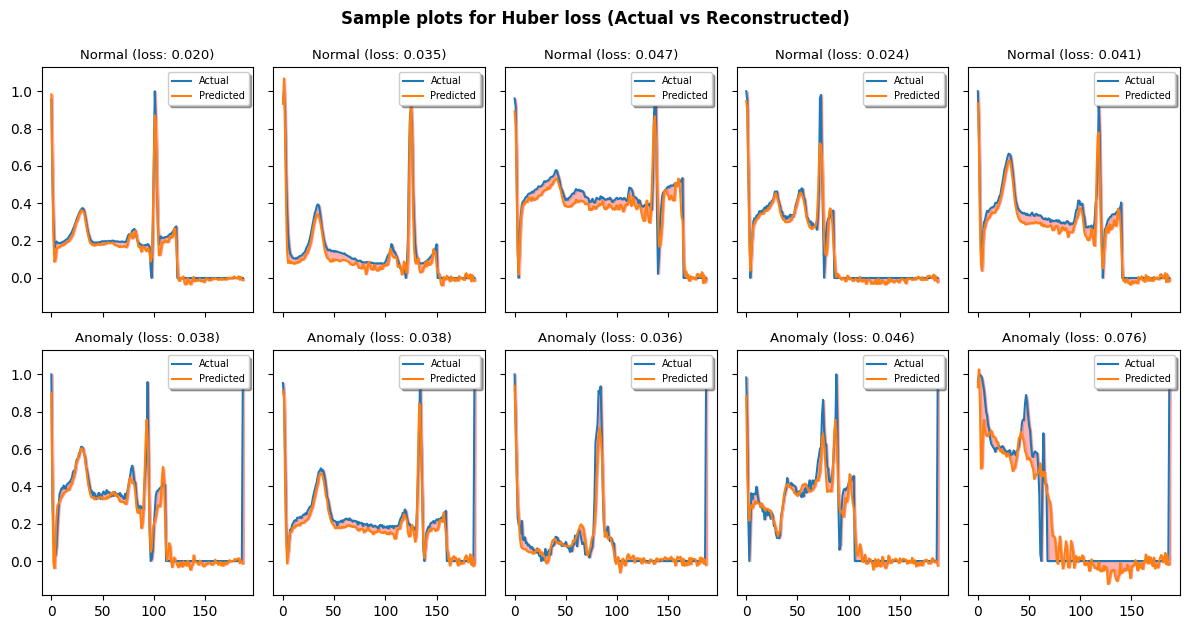

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Accuracy using CosineSimilarity: 15.60%
Validation Reconstruction Error using CosineSimilarity: 78.313968
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


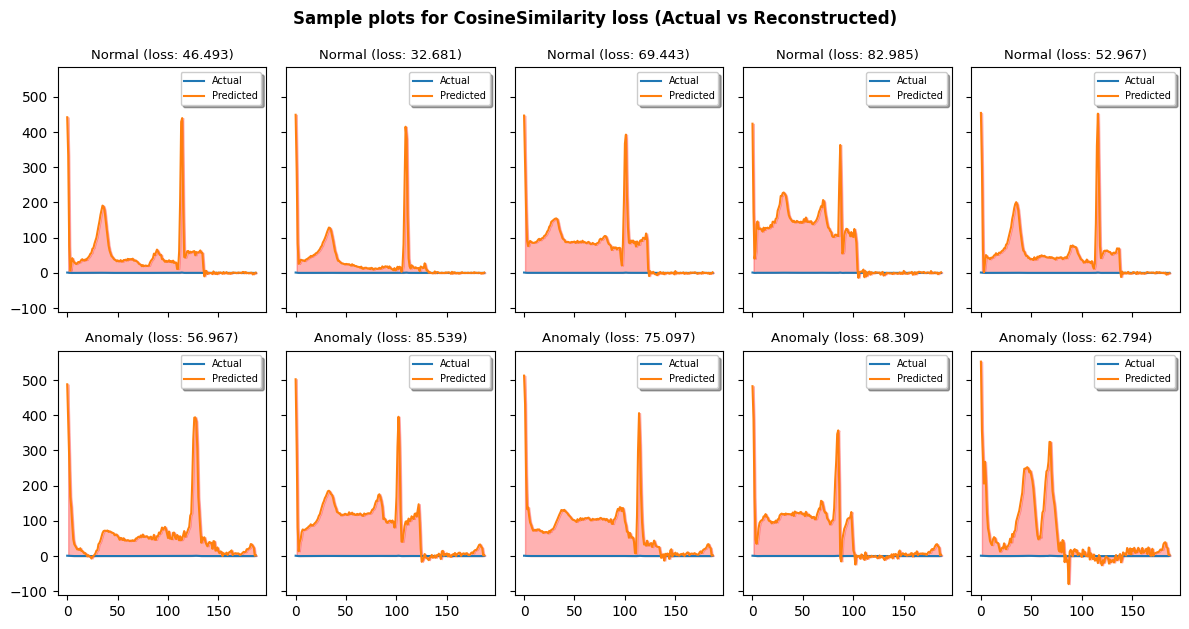

Best Model uses MAE with avg validation error: 0.028576


In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Check if GPU is available
device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Using {device} for training.")

# Train and evaluate models for each loss function
for name, loss_function in loss_functions.items():
    # Define and compile the model
    model = AutoEncoder(input_dim, latent_dim)
    model.build((None, input_dim))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=loss_function)

    # Train the model
    model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
              validation_split=0.1, callbacks=[early_stopping], verbose=0)

    # Calculate the threshold based on the training data
    train_errors = get_reconstruction_error(model, X_train)
    threshold = np.percentile(train_errors, 95)  # 95th percentile as threshold

    # Evaluate the model on combined validation data (normal + anomaly)
    val_errors = get_reconstruction_error(model, X_combined_test)
    y_pred_val = np.array(val_errors > threshold, dtype=int)

    accuracy = accuracy_score(y_test, y_pred_val)

    print(f"Validation Accuracy using {name}: {accuracy:.2%}")
    print(f"Validation Reconstruction Error using {name}: {np.mean(val_errors):.6f}")

    # Visualization: Compare actual vs reconstructed signals
    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(12, 6))
    random_indexes = np.random.randint(0, len(X_train), size=5)

    for i, idx in enumerate(random_indexes):
        plot_examples(model, X_train[[idx]], ax=axes[0, i], title="Normal")
        plot_examples(model, anomaly[[idx]], ax=axes[1, i], title="Anomaly")

    plt.tight_layout()
    fig.suptitle(f"Sample plots for {name} loss (Actual vs Reconstructed)", y=1.04, weight="bold")
    plt.show()

    # Track the best model
    if np.mean(val_errors) < best_loss:
        best_loss = np.mean(val_errors)
        best_model = model
        best_loss_function = name

print(f"Best Model uses {best_loss_function} with avg validation error: {best_loss:.6f}")


# Best model uses MAE with


*   Avg validation error: 0.028576
*   Accuracy: 99.20



In [17]:
# 6. Evaluation
threshold = np.percentile(get_reconstruction_error(best_model, X_train), 95)
normal_errors = get_reconstruction_error(best_model, X_test)
anomaly_errors = get_reconstruction_error(best_model, anomaly)
y_pred_normal = classify_errors(normal_errors, threshold)
y_pred_anomaly = classify_errors(anomaly_errors, threshold)
y_true_normal = np.zeros_like(y_pred_normal)
y_true_anomaly = np.ones_like(y_pred_anomaly)
y_pred = np.concatenate([y_pred_normal, y_pred_anomaly])
y_true = np.concatenate([y_true_normal, y_true_anomaly])
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 99.20%
Precision: 99.50%
Recall: 99.66%
F1 Score: 99.58%


Text(0.5, 36.72222222222221, 'Predicted Class')

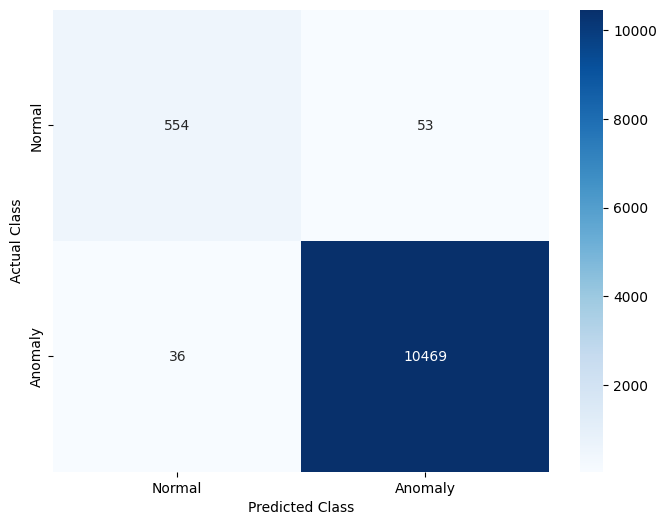

In [18]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')